In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
################# Thank you to all the packages that gave me the strength to make this baby work!!!!! ##########

import pandas as pd
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr 
from scipy import stats
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import math
from pprint import pprint
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import string
from tensorflow.keras.layers import TextVectorization
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import re

import nltk
nltk.download('vader_lexicon')
# Import stopwords with nltk.
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
SHUFFLE_BUFFER = 500
BATCH_SIZE = 5

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
################### Func definitions for MVLogistic #########################
def softmax(h):
  return (np.exp(h.T)/np.sum(np.exp(h), axis=1)).T

def cross_entropy(Y, P_hat):
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat),axis=1),axis=0)

def accuarcy(y, y_hat):
  return np.mean(y==y_hat)

def indices_to_one_hot(data, nb_classes):
  targets = np.array(data).reshape(-1)
  return np.eye(nb_classes)[targets]

In [ ]:
########################## first classification model ###########################
class MVLogisticRegression():

  def __init__(self,thresh=0.4):
    self.thresh = thresh

  def __forward__(self,X):
    return softmax(X@self.W + self.B)

  def fit(self, X, y, eta=2e-1, epochs=1e3, show_curve=False):
    epochs = int(epochs)
    N,D = X.shape
    K= len(np.unique(y))
    y_values= np.unique(y, return_index=False)
    Y= indices_to_one_hot(y, K).astype(int)

    self.W=np.random.randn(D,K)
    self.B = np.random.randn(1,K)

    J= np.zeros(int(epochs))

    for epoch in range(epochs):
      P_hat= self.__forward__(X)
      J[epoch]=cross_entropy(Y, P_hat)

      self.W -=  eta*(1/N)*X.T@(P_hat-Y)
      self.B -= eta*(1/N)*np.sum(P_hat-Y,axis=0)

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")

  

  def predict(self, X):
    return np.argmax(self.__forward__(X), axis=1)

In [ ]:
df = pd.read_csv('/content/Dirty_intersected_words.csv')
df.head()

,String,Label
0,*screams in 25 different languages*,1
1,A group of Florida Forest Service firefighters...,1
2,70 Years After Atomic Bombs Japan Still Strugg...,2
3,Anyway' the old lady went on 'I have something...,2
4,Hi-Res Doppler showing storm just NE of Edmond...,3


In [ ]:
df.drop_duplicates(['String'])
df['String']=df['String'].str.replace(r'https?:\/\/.*[\r\n]*','', case=False)

In [ ]:
######################### function to define classes #################3
def cat(x):
    if  x==0:
      return 0
    if x==1:
      return 1
    if x==2:
      return 1
    if x==3:
      return 2
    if x == 4:
      return 2
df['Label'] = df['Label'].apply(lambda x: cat(x))

In [ ]:
############# check for unbalanced data #############
df['Label'].value_counts()

0    598
1    337
2    179
Name: Label, dtype: int64

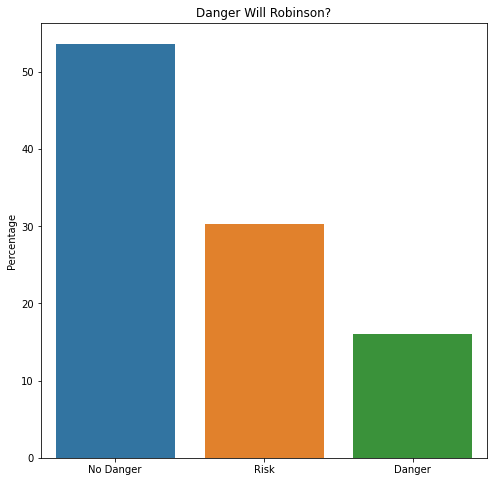

In [ ]:
#################################### Plot category freqeuncies as percentage ###############################
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.Label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)
plt.title('Danger Will Robinson?')
ax.set_xticklabels(['No Danger', 'Risk', 'Danger'])
ax.set_ylabel("Percentage")

plt.show()

In [ ]:
################### take 80% for train and 20% for test data as a training/test size ##############
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 891
Test size: 223


In [ ]:
############### define a data spliting function ##############
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [ ]:
############# Apply the function to actually get a split using the train_size above ###################
train_cat, test_cat = train_test_split(df['Label'], train_size)
train_text, test_text = train_test_split(df['String'], train_size)

In [ ]:
################## View any unbalance in the training categorical variable #############
train_cat.value_counts()

0    470
1    271
2    150
Name: Label, dtype: int64

In [ ]:
################### The fun stuff: hit our sentence with an embedder ######################
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

################## embed train and test texts ##############
train_embeddings = embed(train_text)
test_embeddings = embed(test_text)

In [ ]:
################# Use our hand made MVL #######################
logreg = MVLogisticRegression()

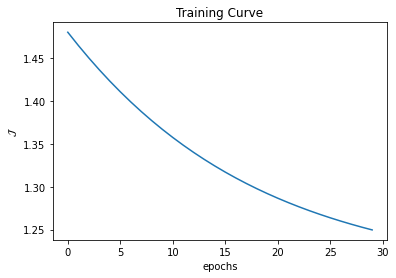

In [ ]:
##################### Train the MVL ####################
logreg.fit(train_embeddings, train_cat, eta=1e-1, epochs=3e1, show_curve=True)

In [ ]:
y_hat_train = logreg.predict(train_embeddings)

In [ ]:
########################## Train accuracy #######################
accuarcy(y_hat_train,train_cat)

0.3782267115600449

In [ ]:
y_hat_test = logreg.predict(test_embeddings)

In [ ]:
########################### Test accuracy #########################
accuarcy(y_hat_test,test_cat)

0.3901345291479821

In [ ]:
################### The fun stuff: hit our sentence with an embedder ######################
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

################## embed train and test texts ##############
train_embeddings = embed(train_text)
test_embeddings = embed(test_text)

In [ ]:
train_embeddings.shape

TensorShape([891, 512])

In [ ]:
###################### Gimme those Tensors baby #############################
train_cat_tensor=tf.convert_to_tensor(train_cat)
test_cat_tensor=tf.convert_to_tensor(test_cat)

In [ ]:
train_cat_tensor.shape

TensorShape([891])

In [ ]:
##################### define a normalizer for the tensor data ###############
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
###################### Define a basic model with three inner layers: we gettin deep in here ##############3
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(12,activation='softmax'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
############## invoke an instance of the model and fit it to the tensors ###############
model = get_basic_model()
model.fit(train_embeddings, train_cat_tensor, epochs=10, batch_size=5, validation_split=0.1)

Epoch 1/10
161/161 [==============================] - 1s 5ms/step - loss: 0.5533 - accuracy: 0.5693 - val_loss: 0.5377 - val_accuracy: 0.6111
Epoch 2/10
161/161 [==============================] - 1s 4ms/step - loss: 0.4137 - accuracy: 0.6230 - val_loss: 0.4965 - val_accuracy: 0.5889
Epoch 3/10
161/161 [==============================] - 1s 4ms/step - loss: 0.3347 - accuracy: 0.6679 - val_loss: 0.5018 - val_accuracy: 0.5778
Epoch 4/10
161/161 [==============================] - 1s 4ms/step - loss: 0.2771 - accuracy: 0.6779 - val_loss: 0.5229 - val_accuracy: 0.5778
Epoch 5/10
161/161 [==============================] - 1s 4ms/step - loss: 0.2098 - accuracy: 0.7016 - val_loss: 0.4343 - val_accuracy: 0.6556
Epoch 6/10
161/161 [==============================] - 1s 4ms/step - loss: 0.1576 - accuracy: 0.7166 - val_loss: 0.5409 - val_accuracy: 0.5222
Epoch 7/10
161/161 [==============================] - 1s 4ms/step - loss: 0.1190 - accuracy: 0.7154 - val_loss: 0.4858 - val_accuracy: 0.5778
Epoch 

In [ ]:
batch_size = 5
######################### Evaluate the accuracy of our trained model #####################
score = model.evaluate(test_embeddings, test_cat_tensor,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.6592
Test loss: 0.4332323372364044
Test accuracy: 0.6591928005218506


In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)
user_input = input()

hello


In [ ]:
tokenize.fit_on_texts(user_input) # fit tokenizer to our training text data
user_sent = tokenize.texts_to_matrix(user_input)